In [1]:
import pandas as pd
import numpy as np

import sys
import os

from sklearn.cluster import KMeans
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Sys.path

In [4]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "Sources")))
# 📥 Import load fonction
from data_loader import load_data

In [6]:
# Load Data from CSV to DataFrame
GMM_Data = load_data('cluster', 'Copper_Data_GMMix.csv')

✅ Load File : /Users/juniormukenze/Documents/00 Personal Research Publication/Research Paper 1/Enhancing Time Series Forecasting with VAE-based Data Augmentation and Temporal Pattern Analysis using Neural Networks/Modules/data/cluster/Copper_Data_GMMix.csv  |  Separator detected: ','


In [8]:
# Convert columns type into int
GMM_Data['year'] = GMM_Data['year'].astype(int)
GMM_Data['month'] = GMM_Data['month'].astype(int)
GMM_Data['Cluster_Label'] = GMM_Data['Cluster_Label'].astype(int)
GMM_Data.shape

(5668, 10)

In [10]:
GMM_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5668 entries, 0 to 5667
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Open           5668 non-null   float64
 1   High           5668 non-null   float64
 2   Low            5668 non-null   float64
 3   Close          5668 non-null   float64
 4   group_id       5668 non-null   int64  
 5   year           5668 non-null   int64  
 6   month          5668 non-null   int64  
 7   day            5668 non-null   int64  
 8   weekday        5668 non-null   int64  
 9   Cluster_Label  5668 non-null   int64  
dtypes: float64(4), int64(6)
memory usage: 442.9 KB


In [12]:
GMM_Data.head(2)

,Open,High,Low,Close,group_id,year,month,day,weekday,Cluster_Label
0,0.393996,0.350258,0.380149,0.340854,0,2013,3,25,0,0
1,0.340330,0.318698,0.358946,0.340854,0,2013,3,27,2,0


In [14]:
GMM_Data['Cluster_Label'].unique()

array([0, 1, 2])

# Split Train and Test

In [17]:
df = GMM_Data.copy()

# Calculation of the cut-off index
split_index = int(len(df) * 0.8)

# Split train/test
df_Train = df.iloc[:split_index]
df_Test = df.iloc[split_index:]


In [19]:
df_Train.shape, df_Test.shape 

((4534, 10), (1134, 10))

# LSTM

In [22]:
df_Train.head(2)

,Open,High,Low,Close,group_id,year,month,day,weekday,Cluster_Label
0,0.393996,0.350258,0.380149,0.340854,0,2013,3,25,0,0
1,0.340330,0.318698,0.358946,0.340854,0,2013,3,27,2,0


In [24]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

def create_dataset(data, feature_col='Close', time_step=3):
    X, y = [], []
    values = data[feature_col].values
    for i in range(len(values) - time_step):
        X.append(values[i:i + time_step])
        y.append(values[i + time_step])
    return np.array(X), np.array(y)

models = {}
histories = {}
time_step = 30

for cluster_id in df_Train['Cluster_Label'].unique():
    df_cluster = df_Train[df_Train['Cluster_Label'] == cluster_id].reset_index(drop=True)
    
    if len(df_cluster) <= time_step:
        print(f" Cluster {cluster_id} ignoré : trop peu de données ({len(df_cluster)})")
        continue

    X, y = create_dataset(df_cluster, time_step=time_step)

    # Reshape X for LSTM: (samples, timesteps, features)
    X = X.reshape((X.shape[0], X.shape[1], 1))  # 1 feature: Average_Close

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
        LSTM(32),
        Dense(1)
    ])
    model.compile(loss='mse', optimizer='adam')
    
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                        epochs=50, verbose=0)

    models[cluster_id] = model
    histories[cluster_id] = history

    print(f"✅ Model trained for the cluster {cluster_id}")


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Model trained for the cluster 0
✅ Model trained for the cluster 1
✅ Model trained for the cluster 2


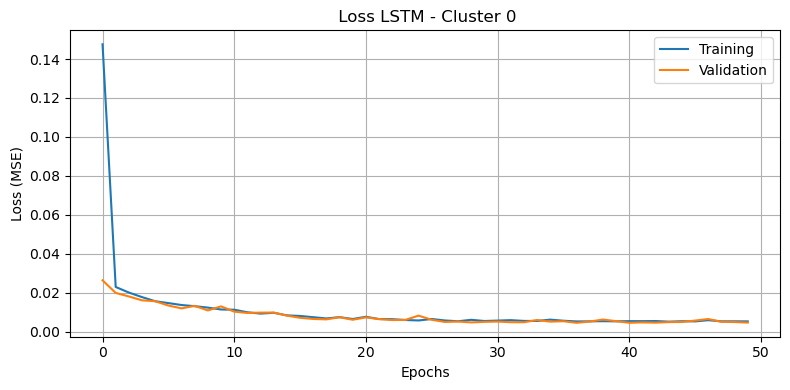

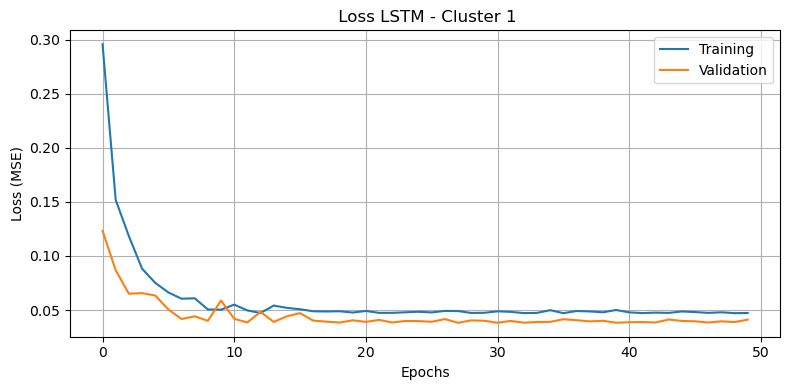

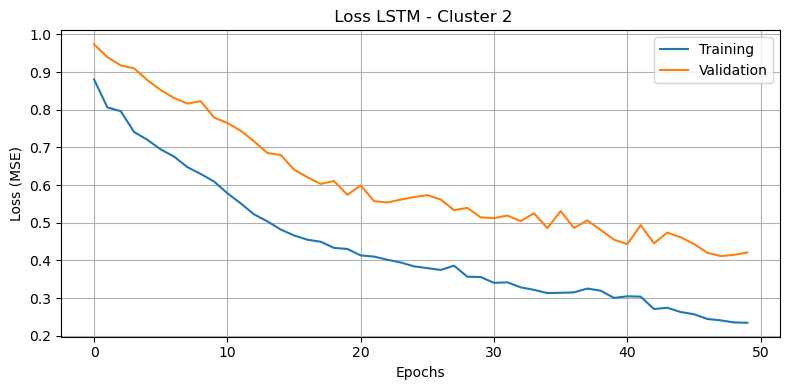

In [25]:
import matplotlib.pyplot as plt

# 📉 Visualization of losses for each cluster
for cluster_id, history in histories.items():
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Training')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f' Loss LSTM - Cluster {cluster_id}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [26]:
df_Test.head(2)

,Open,High,Low,Close,group_id,year,month,day,weekday,Cluster_Label
4534,-0.41628,-0.420736,-0.408761,-0.413227,1,2020,3,25,2,1
4535,-0.41628,-0.420737,-0.408763,-0.413228,1,2020,3,26,3,1


In [27]:
df_Test['Cluster_Label'].unique()

array([1, 2])

Predictions for the cluster 0
Predictions for the cluster 1


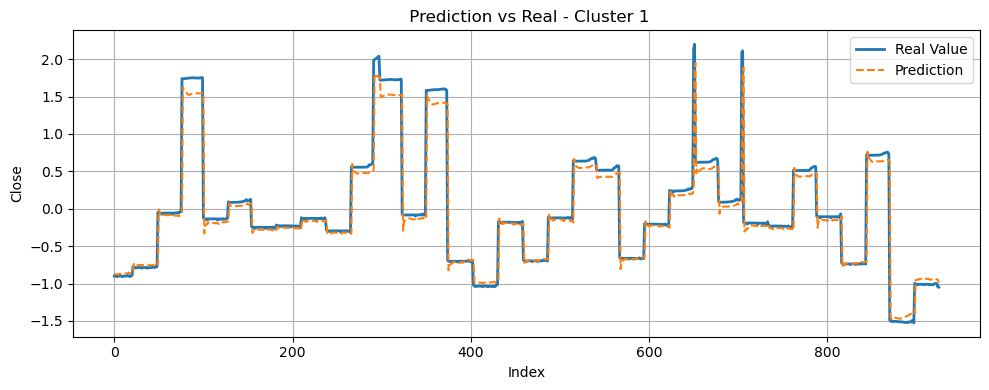

Predictions for the cluster 2


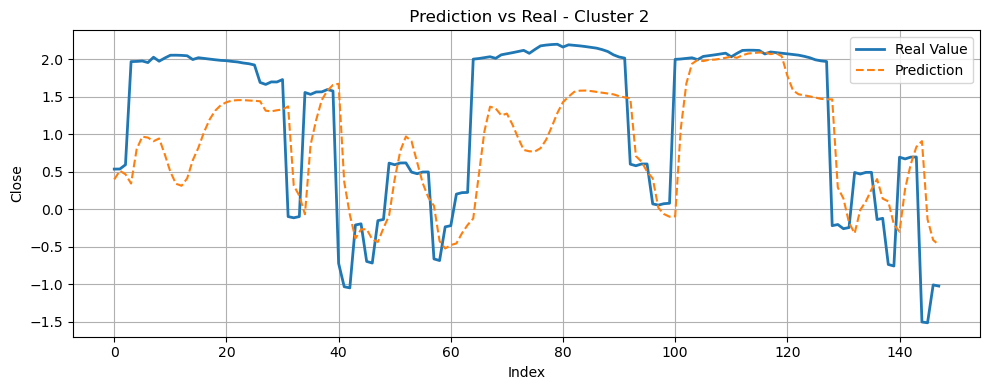

In [29]:
# Visualization of predictions vs. true values by cluster
for cluster_id, model in models.items():
    print(f"Predictions for the cluster {cluster_id}")
    
    df_cluster = df_Test[df_Test['Cluster_Label'] == cluster_id].reset_index(drop=True)
    if len(df_cluster) <= time_step:
        continue

    # Data preparation
    X, y = create_dataset(df_cluster, time_step=time_step)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # Prediction on all X (or just X_test if you want to compare only the test)
    y_pred = model.predict(X, verbose=0).flatten()

    # Ajustement de la taille de y (même que y_pred)
    y_true = y[:len(y_pred)]

    # 🖼 Plot
    plt.figure(figsize=(10, 4))
    plt.plot(y_true, label='Real Value', linewidth=2)
    plt.plot(y_pred, label='Prediction', linestyle='--')
    plt.title(f' Prediction vs Real - Cluster {cluster_id}')
    plt.xlabel('Index')
    plt.ylabel('Close')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Metrics

In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def modified_mape(y_true, y_pred, epsilon=1e-8):
    """mMAPE robuste (évite division par zéro)"""
    return np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + epsilon))) * 100

# 📊 Store results
results = []

for cluster_id, model in models.items():
    df_cluster = GMM_Data[GMM_Data['Cluster_Label'] == cluster_id].reset_index(drop=True)
    if len(df_cluster) <= time_step:
        continue

    # Create Data
    X, y = create_dataset(df_cluster, time_step=time_step)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    y_pred = model.predict(X, verbose=0).flatten()
    y_true = y[:len(y_pred)]

    # Metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mmape = modified_mape(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    results.append({
        "Cluster": cluster_id,
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "mMAPE (%)": mmape,
        "R2 Score": r2
    })

# Plot resultats
results_df = pd.DataFrame(results)
print(results_df)


   Cluster       MSE      RMSE       MAE   mMAPE (%)  R2 Score
0        0  0.004936  0.070259  0.050578   21.089036  0.995645
1        1  0.049680  0.222891  0.090752   28.839487  0.927691
2        2  0.436511  0.660690  0.472830  121.981176  0.647737


/var/folders/cy/gcg43m116b7583kdwdlsg9wh0000gn/T/ipykernel_25993/872938722.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cluster', y=metric, data=results_df, palette='Set2')


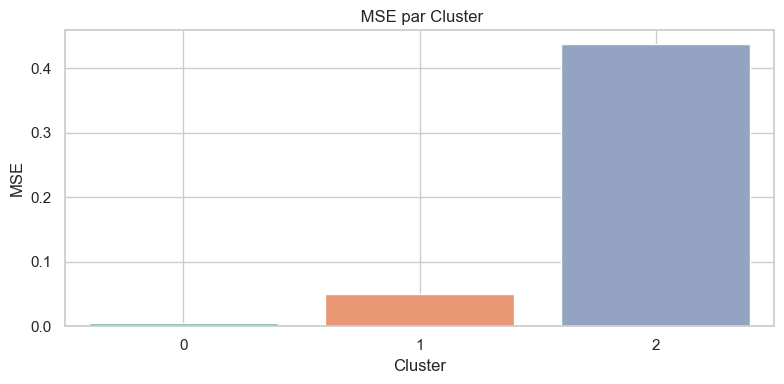

/var/folders/cy/gcg43m116b7583kdwdlsg9wh0000gn/T/ipykernel_25993/872938722.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cluster', y=metric, data=results_df, palette='Set2')


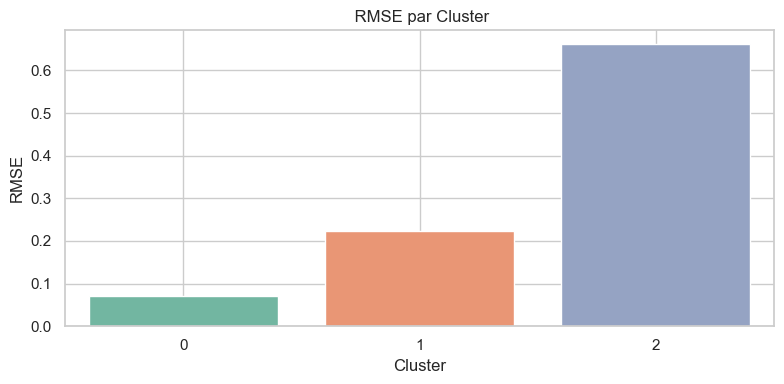

/var/folders/cy/gcg43m116b7583kdwdlsg9wh0000gn/T/ipykernel_25993/872938722.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cluster', y=metric, data=results_df, palette='Set2')


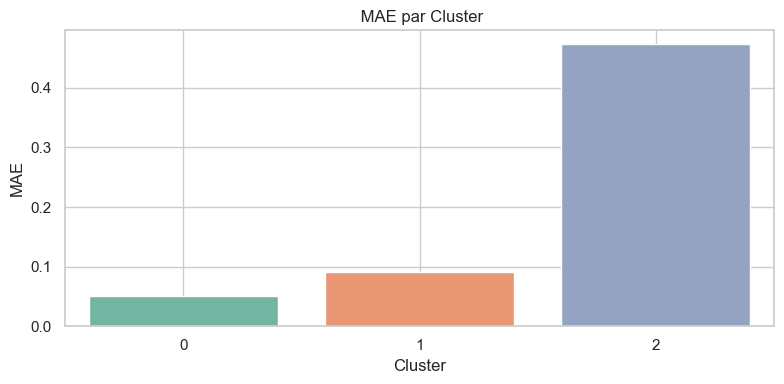

/var/folders/cy/gcg43m116b7583kdwdlsg9wh0000gn/T/ipykernel_25993/872938722.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cluster', y=metric, data=results_df, palette='Set2')


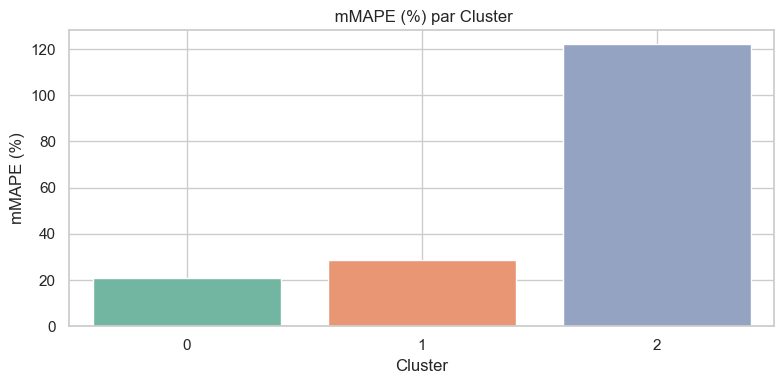

/var/folders/cy/gcg43m116b7583kdwdlsg9wh0000gn/T/ipykernel_25993/872938722.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cluster', y=metric, data=results_df, palette='Set2')


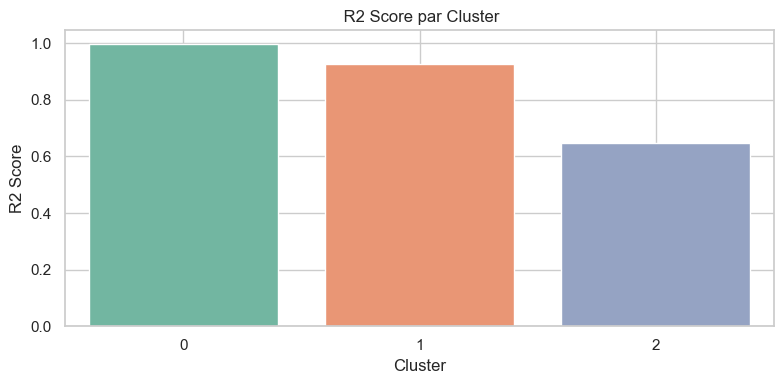

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Style
sns.set(style="whitegrid")

# List of Metrics
metrics = ['MSE', 'RMSE', 'MAE', 'mMAPE (%)', 'R2 Score']

# Plot Metrics
for metric in metrics:
    plt.figure(figsize=(8, 4))
    sns.barplot(x='Cluster', y=metric, data=results_df, palette='Set2')
    plt.title(f' {metric} par Cluster')
    plt.ylabel(metric)
    plt.xlabel("Cluster")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.grid(True)
    plt.show()


# LSTM With Copper Data original and Gaussian Mixture Model

In [35]:
# Load Data from CSV to DataFrame
GMM_O_Data = load_data('cluster', 'Copper_Data_GMM_O.csv')

✅ Load File : /Users/juniormukenze/Documents/00 Personal Research Publication/Research Paper 1/Enhancing Time Series Forecasting with VAE-based Data Augmentation and Temporal Pattern Analysis using Neural Networks/Modules/data/cluster/Copper_Data_GMM_O.csv  |  Separator detected: ','


In [36]:
GMM_O_Data['year'] = GMM_O_Data['year'].astype(int)
GMM_O_Data['month'] = GMM_O_Data['month'].astype(int)
GMM_O_Data['Cluster_Label'] = GMM_O_Data['Cluster_Label'].astype(int)
GMM_O_Data.shape

(2834, 10)

## Split Train and Test

In [38]:
df2 = GMM_O_Data.copy()
split_index2 = int(len(df2) * 0.8)

# 4. Division train/test
df_Train2 = df2.iloc[:split_index2]
df_Test2 = df2.iloc[split_index2:]

In [39]:
df_Train2.shape, df_Test2.shape 

((2267, 10), (567, 10))

## Model - Train

In [41]:
for cluster_id in df_Train2['Cluster_Label'].unique():
    df_cluster = df_Train2[df_Train2['Cluster_Label'] == cluster_id].reset_index(drop=True)
    
    if len(df_cluster) <= time_step:
        print(f"⚠️ Cluster {cluster_id} ignoré : trop peu de données ({len(df_cluster)})")
        continue

    X, y = create_dataset(df_cluster, time_step=time_step)

    # Reshape X for LSTM: (samples, timesteps, features)
    X = X.reshape((X.shape[0], X.shape[1], 1))  # 1 feature: Average_Close

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
        LSTM(32),
        Dense(1)
    ])
    model.compile(loss='mse', optimizer='adam')
    
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                        epochs=50, verbose=0)

    models[cluster_id] = model
    histories[cluster_id] = history

    print(f"✅ Modèle entraîné pour le cluster {cluster_id}")


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Modèle entraîné pour le cluster 1
✅ Modèle entraîné pour le cluster 2
✅ Modèle entraîné pour le cluster 0


## Visualization training

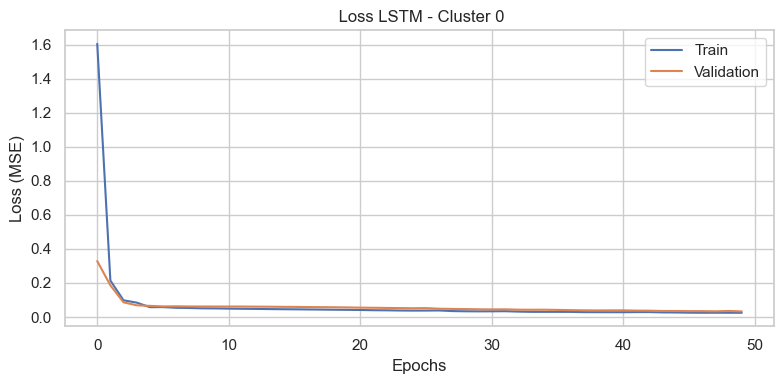

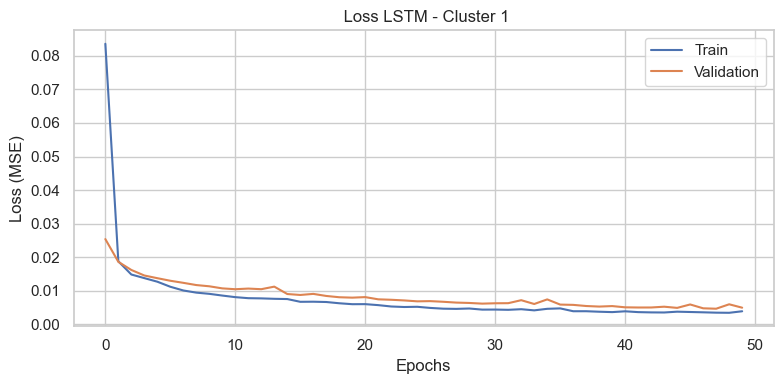

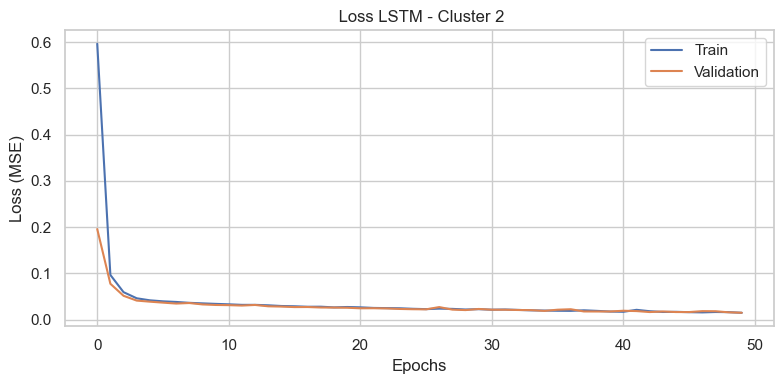

In [43]:
import matplotlib.pyplot as plt

# 📉 Visualisation des pertes pour chaque cluster
for cluster_id, history in histories.items():
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f' Loss LSTM - Cluster {cluster_id}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## Model - Predict

In [45]:
df_Test2.head(3)

,Open,High,Low,Close,group_id,year,month,day,weekday,Cluster_Label
2267,1.745341,1.702783,1.744051,1.760917,0,2022,6,8,2,0
2268,1.747453,1.694460,1.685447,1.657453,0,2022,6,9,3,0
2269,1.639059,1.599438,1.569668,1.535688,0,2022,6,10,4,0


📈 Prédictions pour le cluster 0


/var/folders/cy/gcg43m116b7583kdwdlsg9wh0000gn/T/ipykernel_25993/3227296932.py:28: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Arial.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


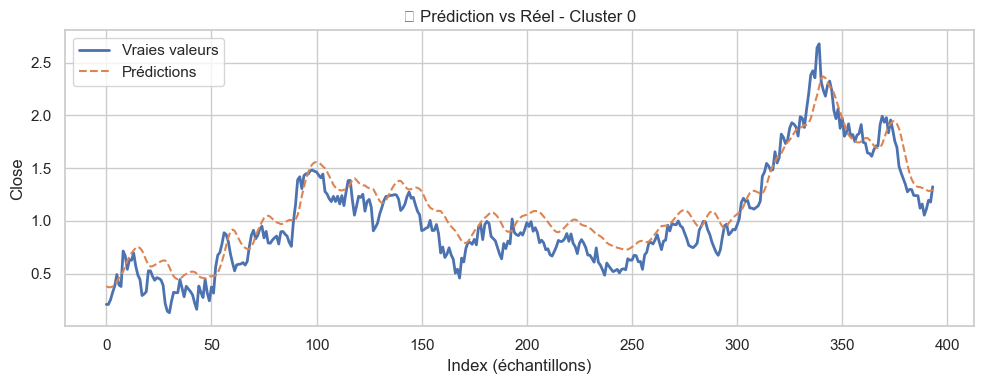

📈 Prédictions pour le cluster 1
📈 Prédictions pour le cluster 2


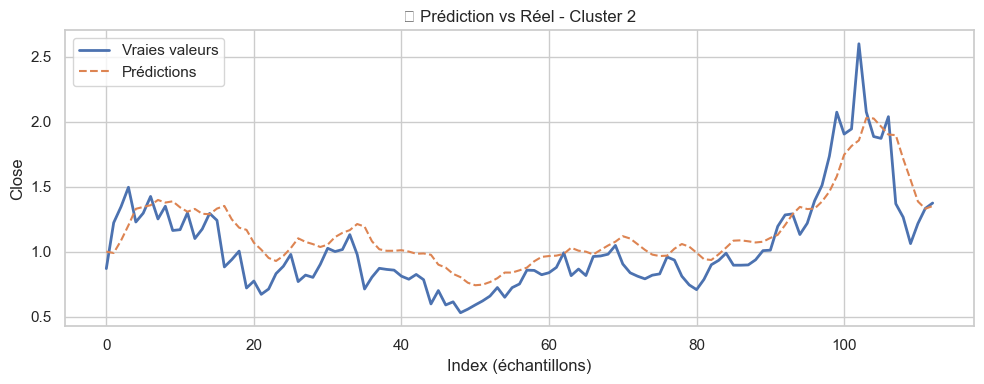

In [46]:
# 🔍 Visualisation des prédictions vs vraies valeurs par cluster
for cluster_id, model in models.items():
    print(f"📈 Prédictions pour le cluster {cluster_id}")
    
    df_cluster = df_Test2[df_Test2['Cluster_Label'] == cluster_id].reset_index(drop=True)
    if len(df_cluster) <= time_step:
        continue

    # Préparation des données
    X, y = create_dataset(df_cluster, time_step=time_step)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # Prédiction sur tout X (ou juste X_test si vous voulez comparer seulement le test)
    y_pred = model.predict(X, verbose=0).flatten()

    # Ajustement de la taille de y (même que y_pred)
    y_true = y[:len(y_pred)]

    # 🖼 Affichage
    plt.figure(figsize=(10, 4))
    plt.plot(y_true, label='Vraies valeurs', linewidth=2)
    plt.plot(y_pred, label='Prédictions', linestyle='--')
    plt.title(f'🎯 Prédiction vs Réel - Cluster {cluster_id}')
    plt.xlabel('Index (échantillons)')
    plt.ylabel('Close')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [47]:
## Metrics

In [48]:
# Store results
results = []

for cluster_id, model in models.items():
    df_cluster = df_Test2[df_Test2['Cluster_Label'] == cluster_id].reset_index(drop=True)
    if len(df_cluster) <= time_step:
        continue

    # Créer les données
    X, y = create_dataset(df_cluster, time_step=time_step)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    y_pred = model.predict(X, verbose=0).flatten()
    y_true = y[:len(y_pred)]

    # 🔢 Calcul des métriques
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mmape = modified_mape(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    results.append({
        "Cluster": cluster_id,
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "mMAPE (%)": mmape,
        "R2 Score": r2
    })

# Plot results
results_df = pd.DataFrame(results)
print(results_df)

   Cluster       MSE     RMSE       MAE  mMAPE (%)  R2 Score
0        0  0.034548  0.18587  0.155651  23.343187  0.858649
1        2  0.046708  0.21612  0.172951  18.831261  0.654800
